<a href="https://colab.research.google.com/github/MatheoCruz/BLR_imputation_perovskite/blob/main/Preprocesamiento_base_datos_complementaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importamos las librerias necesarias

In [2]:
#Import LIbraries
import pandas as pd
import numpy as np
from functools import partial
from scipy.stats import norm
import matplotlib.pyplot as plt
from pandas.core.arrays.arrow import array
import seaborn as sns
from tables.flavor import array_of_flavor2

Se crean las funciones necesarias para las caracteristicas unicas de cada variable

In [3]:
#functions
def es_rango(valor):
    if type(valor) == str and '-' in valor:
        return True
    else:
        return False
def CaracterEspecial(array):
    arr = array.astype(str)
    arr_str = np.vectorize(str)(arr)
    mask = np.char.find(arr_str, '|') > -1
    # Reemplazar los valores por NaN
    array[mask] = np.nan
    return array
def StrtoFloat(array):
    indices_rangos = np.nonzero(array.apply(es_rango).values)[0]
    for indice in indices_rangos:
      valores = array[indice].split("-")
      promedio = (float(valores[0]) + float(valores[1])) / 2
      array[indice] = promedio
    return array.astype(float)
def CoefficientsConvert(array):
    size = len(array)
    arrays = array
    array = [str(array) for array in arrays]
    new_array = []
    for i in range(size):
      elements = array[i].split(';')
      result = [0.0, 0.0, 0.0, 0.0]
      for j in range(min(4, len(elements))):
        try:
          result[j] = float(elements[j])
        except ValueError:
          pass
      new_array.append(result)
    return new_array
def ionA(arr):
    return arr[2]-arr[1]-arr[0]
def ionB(arr):
    return arr[1]-arr[0]
def ionX(arr):
    return arr[2]+arr[1]-arr[0]
def IonsCoeffientes(composition, coefficients, funcion, name):
    lista = np.zeros((composition.shape))
    salida = []
    if len(coefficients.iloc[0]) - len(composition.iloc[0]) != 1:
      coefficients = coefficients.iloc[:,:-1]
    else:
      pass
    for i in range(0,len(composition)):
      num_true = (composition.loc[i] == True).sum()
      num_mayor_cero = (coefficients.loc[i] > 0).sum()
      posiciones = np.where(composition.iloc[i] == True)[0]
      if num_true == 0:
        salida.append(None)
      else:
        arr = np.zeros(len(composition.iloc[0]))
        if num_mayor_cero-num_true > 0:
          arr_temp = coefficients.iloc[i][1:]
          j=1
          for posicion in posiciones:
            arr[posicion] = arr_temp[j]
            j+1
        elif num_mayor_cero == num_true:
          arr_temp = coefficients.iloc[i][:-1]
          j=0
          for posicion in posiciones:
            arr[posicion] = arr_temp[j]
            j+1
        lista[i]=arr
        salida.append(funcion(lista[i]))
    salida = {name:salida}
    return salida

In [4]:
#Load DataBase
df = pd.read_csv("/content/drive/MyDrive/Deep Learning/TG/Preprocesamiento/Perovskite_database_content_all_data.csv")
print(df.head(0))

<ipython-input-4-a7d0e2bd8234>:2: DtypeWarning: Columns (10,22,29,31,32,35,36,40,44,45,46,48,51,54,65,84,89,90,93,98,99,100,105,108,115,118,122,123,125,130,134,138,142,143,144,146,149,152,163,166,167,171,172,173,175,178,181,192,194,225,271,272,273,277,304,315,321,325,330,331,335,336,342,348,369,371,373,374,376,380,384,387,403,405,407,409) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/Deep Learning/TG/Preprocesamiento/Perovskite_database_content_all_data.csv")


Empty DataFrame
Columns: [Ref_ID, Ref_ID_temp, Ref_name_of_person_entering_the_data, Ref_data_entered_by_author, Ref_DOI_number, Ref_lead_author, Ref_publication_date, Ref_journal, Ref_part_of_initial_dataset, Ref_original_filename_data_upload, Ref_free_text_comment, Ref_internal_sample_id, Cell_stack_sequence, Cell_area_total, Cell_area_measured, Cell_number_of_cells_per_substrate, Cell_architecture, Cell_flexible, Cell_flexible_min_bending_radius, Cell_semitransparent, Cell_semitransparent_AVT, Cell_semitransparent_wavelength_range, Cell_semitransparent_raw_data, Module, Module_number_of_cells_in_module, Module_area_total, Module_area_effective, Module_JV_data_recalculated_per_cell, Substrate_stack_sequence, Substrate_thickness, Substrate_area, Substrate_supplier, Substrate_brand_name, Substrate_deposition_procedure, Substrate_surface_roughness_rms, Substrate_etching_procedure, Substrate_cleaning_procedure, ETL_stack_sequence, ETL_thickness, ETL_additives_compounds, ETL_additives_con

Extraccion de variables de la base de datos

In [5]:
#Load data sets
df_ref = df.filter(regex='Ref')
df_cell = df.filter(regex = "Cell")
df_module = df.filter(regex = "Module")
df_substrate = df.filter(regex = "Substrate")
df_ETL = df.filter(regex = "ETL")
df_perovskite = df.filter(regex = "Perovskite")
df_HTL = df.filter(regex = "HTL")
df_Backcontact = df.filter(regex = "Backcontact")
df_add_lay = df.filter(regex ="Add_lay")
df_Encapsulation = df.filter(regex = "Encapsulation")
df_JV = df.filter(regex = "JV")
df_stabilised = df.filter(regex = "Stabilised")
df_EQE = df.filter(regex = "EQE")
df_stability = df.filter(regex = "Stability")
df_outdoor = df.filter(regex = "Outdoor")

Extraccion de informacion relevante

In [6]:
#Extraction of relevant information
#Ion coefficients
perovskite_composition_a_ions = df_perovskite["Perovskite_composition_a_ions"]
perovskite_composition_a_ions_coefficients = df_perovskite["Perovskite_composition_a_ions_coefficients"]
perovskite_composition_b_ions = df_perovskite["Perovskite_composition_b_ions"]
perovskite_composition_b_ions_coefficients = df_perovskite["Perovskite_composition_b_ions_coefficients"]
perovskite_composition_c_ions = df_perovskite["Perovskite_composition_c_ions"]
perovskite_composition_c_ions_coefficients = df_perovskite["Perovskite_composition_c_ions_coefficients"]
#Thickness and bandgap
perovskite_thickness = df_perovskite["Perovskite_thickness"]
perovskite_band_gap = df_perovskite["Perovskite_band_gap"]
#Outputs
Voc = df_JV["JV_default_Voc"]
Jsc = df_JV["JV_default_Jsc"]
FF = df_JV["JV_default_FF"]
PCE = df_JV["JV_default_PCE"]

Creacion de un nuevo set de datos

In [7]:
data = {'Composition_A':perovskite_composition_a_ions,
        'Coefficients_A':perovskite_composition_a_ions_coefficients,
        'Composition_B':perovskite_composition_b_ions,
        'Coefficients_B':perovskite_composition_b_ions_coefficients,
        'Composition_X':perovskite_composition_c_ions,
        'Coefficients_X':perovskite_composition_c_ions_coefficients,
        'Thickness':perovskite_thickness,
        'Band_gap':perovskite_band_gap,
        'Voc':Voc,
        'Jsc':Jsc,
        'FF':FF,
        'PCE':PCE}
data = pd.DataFrame(data)
print(data)

      Composition_A Coefficients_A Composition_B Coefficients_B Composition_X  \
0                Cs              1            Sn              1             I   
1                Cs              1            Sn              1         Br; I   
2                Cs              1            Sn              1         Br; I   
3                Cs              1            Sn              1         Br; I   
4                Cs              1            Sn              1            Br   
...             ...            ...           ...            ...           ...   
42492            MA            1.0        Ag; Pb       0.1; 0.9            Br   
42493            MA            1.0        Ag; Pb     0.02; 0.98            Br   
42494            MA            1.0        Ag; Pb     0.02; 0.98            Br   
42495            MA            1.0        Ag; Pb     0.05; 0.95            Br   
42496           NaN            NaN        Ag; Pb   0.005; 0.995           NaN   

      Coefficients_X Thickn

In [8]:
tipos = data.dtypes
print(tipos)

Composition_A      object
Coefficients_A     object
Composition_B      object
Coefficients_B     object
Composition_X      object
Coefficients_X     object
Thickness          object
Band_gap           object
Voc               float64
Jsc               float64
FF                float64
PCE               float64
dtype: object


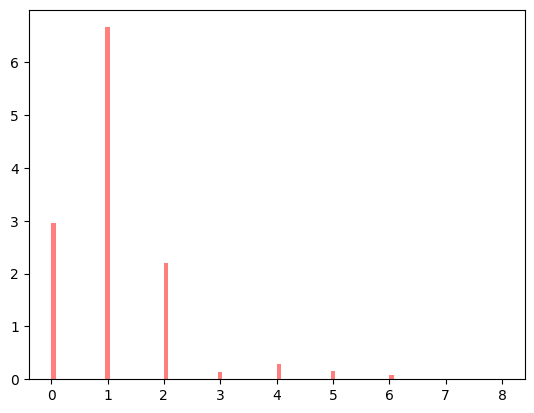

In [9]:
#Numero de nans por fila
N,n = data.shape
num_nans_por_fila = data.isnull().sum(axis=1)
plt.hist(num_nans_por_fila, bins=100, density=True, color='r', alpha=0.5)
plt.show()

In [10]:
data['Composition_A']=CaracterEspecial(data['Composition_A'])
print(data['Composition_A'].isna().sum())
data['Coefficients_A']=CaracterEspecial(data['Coefficients_A'])
print(data['Coefficients_A'].isna().sum())
data['Composition_B']=CaracterEspecial(data['Composition_B'])
print(data['Composition_B'].isna().sum())
data['Coefficients_B']=CaracterEspecial(data['Coefficients_B'])
print(data['Coefficients_B'].isna().sum())
data['Composition_X']=CaracterEspecial(data['Composition_X'])
print(data['Composition_X'].isna().sum())
data['Coefficients_X']=CaracterEspecial(data['Coefficients_X'])
print(data['Coefficients_X'].isna().sum())

<ipython-input-3-537f86bbf83c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  array[mask] = np.nan


293
321
267
296
269
303


Extraccion de los iones A, B, X de interes

In [11]:
#Para A
size = len(data['Composition_A'])
MA_list = []
FA_list = []
Cs_list = []
for i in range(size):
  composition_str = str(data['Composition_A'][i]) # Convertir a cadena
  Cs_list.append("Cs" in composition_str)
  FA_list.append("FA" in composition_str)
  MA_list.append("MA" in composition_str)
A_composition= {'Cs':Cs_list, 'FA':FA_list, 'MA':MA_list}
A_composition = pd.DataFrame(A_composition)
A_coefficients = CoefficientsConvert(data['Coefficients_A'])
A_coefficients = pd.DataFrame(A_coefficients)

In [12]:
#Para B
size = len(data['Composition_B'])
Pb_list = []
Sn_list = []
for i in range(size):
  composition_str = str(data['Composition_B'][i]) # Convertir a cadena
  Pb_list.append("Pb" in composition_str)
  Sn_list.append("Sn" in composition_str)
B_composition= {'Pb':Pb_list, 'Sn':Sn_list}
B_composition = pd.DataFrame(B_composition)
B_coefficients = CoefficientsConvert(data['Coefficients_B'])
B_coefficients = pd.DataFrame(B_coefficients)

In [13]:
#Para X
size = len(data['Composition_X'])
Br_list = []
Cl_list = []
I_list = []
for i in range(size):
  composition_str = str(data['Composition_X'][i]) # Convertir a cadena
  Br_list.append("Br" in composition_str)
  Cl_list.append("Cl" in composition_str)
  I_list.append("I" in composition_str)
X_composition= {'Br':Br_list, 'Cl':Cl_list, 'I':I_list}
X_composition = pd.DataFrame(X_composition)
X_coefficients = CoefficientsConvert(data['Coefficients_X'])
X_coefficients = pd.DataFrame(X_coefficients)

Transformacion de las variables A, B, X
Cs, FA, MA = MA-FA-Cs

Pb, Sn = Pb-Sn

Br,Cl, I = I+Cl-Br

In [14]:
A = IonsCoeffientes(A_composition, A_coefficients, ionA, 'A')
B = IonsCoeffientes(B_composition, B_coefficients, ionB, 'B')
X = IonsCoeffientes(X_composition, X_coefficients, ionX, 'X')

In [15]:
data['Thickness'] = StrtoFloat(CaracterEspecial(data['Thickness']))
data['Band_gap'] = StrtoFloat(CaracterEspecial(data['Band_gap']))

<ipython-input-3-537f86bbf83c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  array[mask] = np.nan


In [16]:
datos = {'A':np.asarray(A['A']), 'B':np.asarray(B['B']), 'X':np.asarray(X['X']), 'Thickness':np.asarray(data['Thickness'])/1000, 'Bandgap':np.asarray(data['Band_gap']), 'Voc': np.asarray(Voc), 'Jsc':np.asarray(Jsc), 'FF':np.asarray(FF), 'PCE':np.asarray(PCE)}
datos = pd.DataFrame(datos)
print(datos.shape)

(42497, 9)


Rango limite por variables

In [17]:
datos_limitados = datos
datos_limitados['A'] = np.where((datos_limitados['A'] <= -3) | (datos_limitados['A'] >= 3), np.nan, datos_limitados['A'])
datos_limitados['B'] = np.where((datos_limitados['B'] <= -3) | (datos_limitados['B'] >= 3), np.nan, datos_limitados['B'])
datos_limitados['X'] = np.where((datos_limitados['X'] <= -3) | (datos_limitados['X'] >= 3), np.nan, datos_limitados['X'])
datos_limitados['Thickness'] = np.where((datos_limitados['Thickness'] <= 0) | (datos_limitados['Thickness'] >= 1), np.nan, datos_limitados['Thickness'])
datos_limitados['Bandgap'] = np.where((datos_limitados['Bandgap'] <= 1) | (datos_limitados['Bandgap'] >= 2.5), np.nan, datos_limitados['Bandgap'])
datos_limitados['Voc'] = np.where((datos_limitados['Voc'] <= 0) | (datos_limitados['Voc'] >= 2), np.nan, datos_limitados['Voc'])
datos_limitados['Jsc'] = np.where((datos_limitados['Jsc'] <= 0.5) | (datos_limitados['Jsc'] >= 30), np.nan, datos_limitados['Jsc'])
datos_limitados['FF'] = np.where((datos_limitados['FF'] <= 0) | (datos_limitados['FF'] >= 100), np.nan, datos_limitados['FF'])
datos_limitados['PCE'] = np.where((datos_limitados['PCE'] <= 0) | (datos_limitados['PCE'] >= 25), np.nan, datos_limitados['PCE'])

Extraccion de la grilla a traves de un Kernel y su correspondiente gradifa de densidad de probabilidad

<ipython-input-18-c82db3e0b572>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  kde = sns.distplot(datos_limitados[datos_limitados.columns[j]], kde=True, hist = True,
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2511: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.25`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
<ipython-input-18-c82db3e0b572>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please

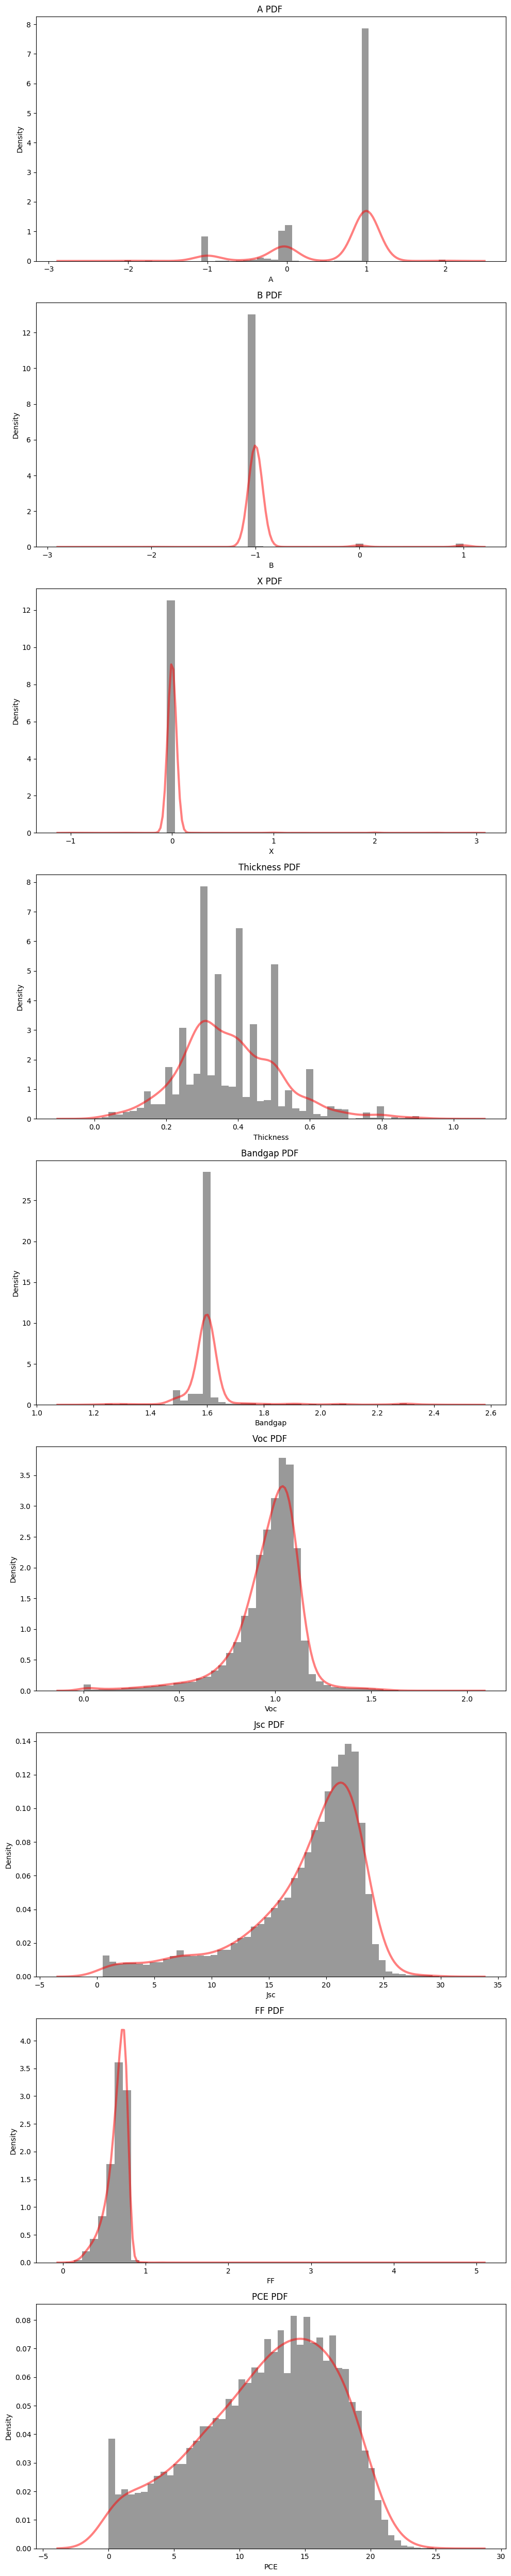

In [18]:
#Extraccion de prior sin normalizar
#Graficos sin eliminar datos atipicos o fuera de rango
# Crear un conjunto de ejes
fig, axes = plt.subplots(nrows=9, ncols=1, figsize=(10, 50))
kde_x = []
kde_y = []
# Graficar el primer histograma
for j in range(0,9):
  kde = sns.distplot(datos_limitados[datos_limitados.columns[j]], kde=True, hist = True,
               kde_kws={"linewidth": 3, "color": "red", "alpha": 0.5, "bw":0.25},
               hist_kws={"alpha": 0.8, "color": "gray"},
               ax=axes[j])
  grid = kde.get_lines()[0].get_data()
  grid_x = {datos_limitados.columns[j]:grid[0]}
  grid_y = {datos_limitados.columns[j]:grid[1]}
  kde_x.append(grid_x)
  kde_y.append(grid_y)
  axes[j].set_title(datos.columns[j] +" PDF ")
  plt.tight_layout()
plt.show()

<ipython-input-19-2e19f8c0ae89>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  kde = sns.distplot(datos_normalizados[datos_normalizados.columns[j]], kde=True, hist = True,
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2511: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.25`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
<ipython-input-19-2e19f8c0ae89>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

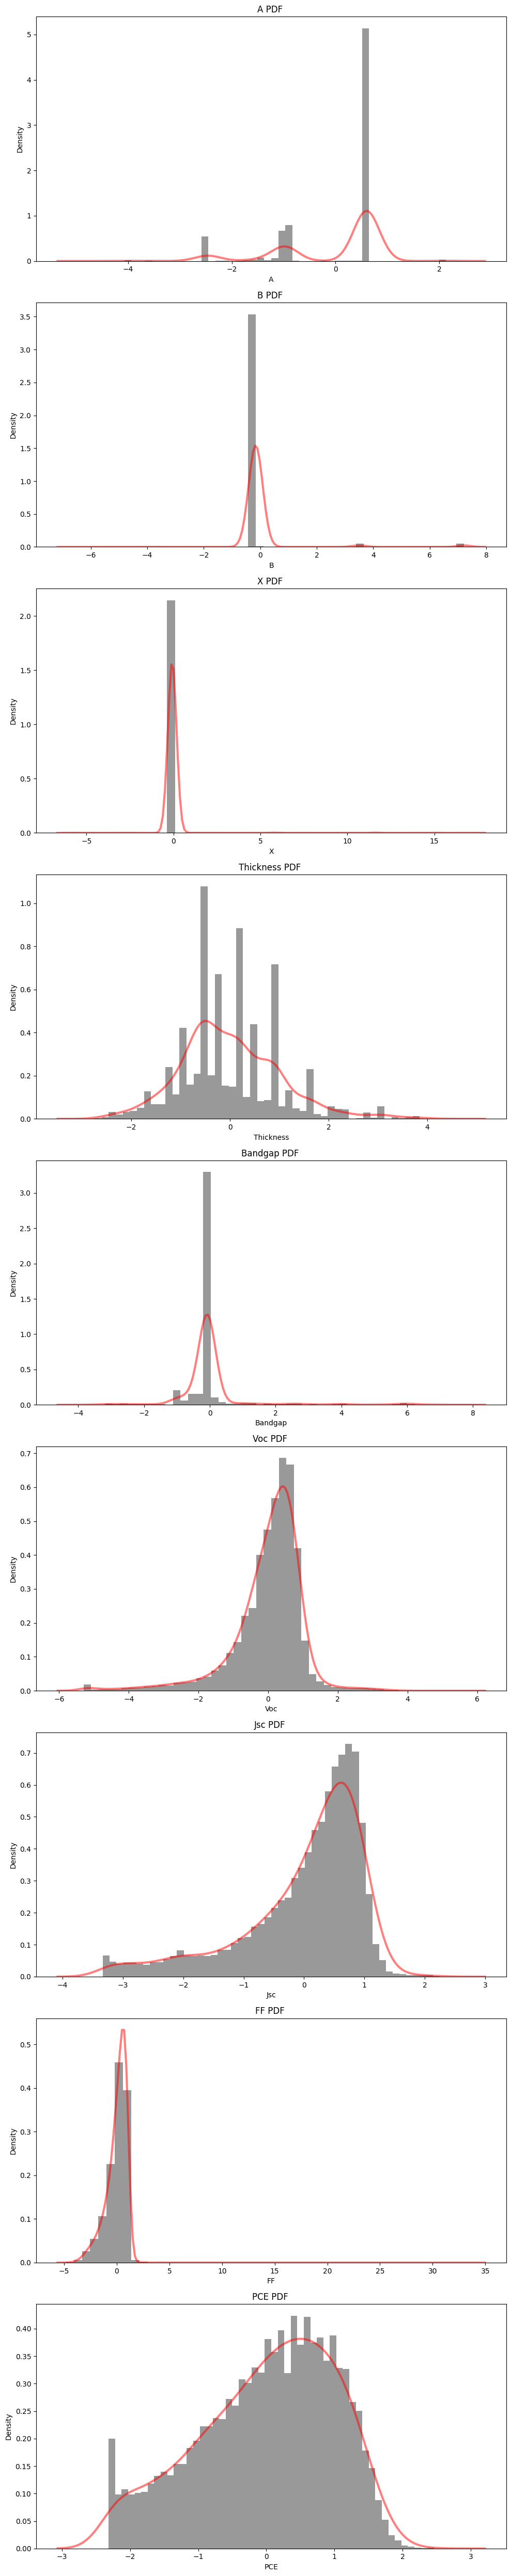

In [19]:
#Extraccion de prior normalizado
mean = np.mean(datos_limitados, axis = 0)
std = np.std(datos_limitados, axis = 0)
datos_normalizados = (datos_limitados-mean)/std
#Graficos sin eliminar datos atipicos o fuera de rango
# Crear un conjunto de ejes
fig, axes = plt.subplots(nrows=9, ncols=1, figsize=(10, 50))
kde_x_normalizado = []
kde_y_normalizado = []
# Graficar el primer histograma
for j in range(0,9):
  kde = sns.distplot(datos_normalizados[datos_normalizados.columns[j]], kde=True, hist = True,
               kde_kws={"linewidth": 3, "color": "red", "alpha": 0.5, "bw":0.25},
               hist_kws={"alpha": 0.8, "color": "gray"},
               ax=axes[j])
  grid = kde.get_lines()[0].get_data()
  grid_x_normalizado = {datos_normalizados.columns[j]:grid[0]}
  grid_y_normalizado = {datos_normalizados.columns[j]:grid[1]}
  kde_x_normalizado.append(grid_x_normalizado)
  kde_y_normalizado.append(grid_y_normalizado)
  axes[j].set_title(datos.columns[j] +" PDF ")
  plt.tight_layout()
plt.show()

<ipython-input-28-7b9ef1300671>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  kde = sns.distplot(datos_limitados[datos_limitados.columns[8]], kde=True, hist = True,
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2511: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.25`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


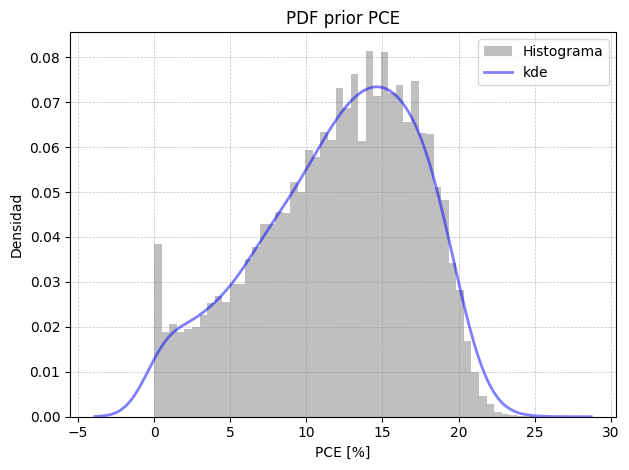

In [28]:
grid_style = {'color': 'gray', 'linestyle': '--', 'linewidth': 0.5, 'alpha': 0.5}
kde = sns.distplot(datos_limitados[datos_limitados.columns[8]], kde=True, hist = True,
               kde_kws={"linewidth": 2, "color": "blue", "alpha": 0.5, "bw":0.25, "label" : "kde"},
               hist_kws={"alpha": 0.5, "color": "gray", "label":"Histograma"})
plt.title("PDF prior PCE")
plt.xlabel("PCE [%]")
plt.ylabel("Densidad")
plt.legend()
plt.grid(True, **grid_style)
plt.tight_layout()

<ipython-input-29-a9ba7aec799e>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  kde = sns.distplot(datos_normalizados[datos_normalizados.columns[8]], kde=True, hist = True,
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2511: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.25`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


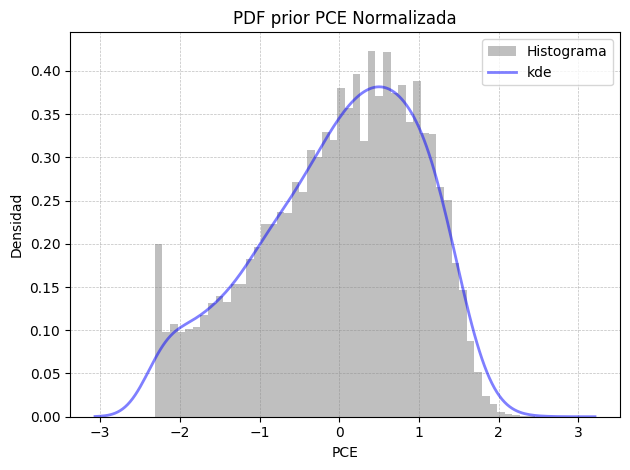

In [29]:
grid_style = {'color': 'gray', 'linestyle': '--', 'linewidth': 0.5, 'alpha': 0.5}
kde = sns.distplot(datos_normalizados[datos_normalizados.columns[8]], kde=True, hist = True,
               kde_kws={"linewidth": 2, "color": "blue", "alpha": 0.5, "bw":0.25, "label" : "kde"},
               hist_kws={"alpha": 0.5, "color": "gray", "label":"Histograma"})
plt.title("PDF prior PCE Normalizada")
plt.xlabel("PCE")
plt.ylabel("Densidad")
plt.legend()
plt.grid(True, **grid_style)
plt.tight_layout()

In [23]:
KDE_X = {'A':kde_x_normalizado[0]['A'], 'B':kde_x_normalizado[1]['B'], 'X':kde_x_normalizado[2]['X'], 'Thickness':kde_x_normalizado[3]['Thickness'], 'Bandgap':kde_x_normalizado[4]['Bandgap'], 'Voc':kde_x_normalizado[5]['Voc'], 'Jsc':kde_x_normalizado[6]['Jsc'], 'FF':kde_x_normalizado[7]['FF'], 'PCE':kde_x_normalizado[8]['PCE']}
KDE_X = pd.DataFrame(KDE_X)
KDE_Y = {'A':kde_y_normalizado[0]['A'], 'B':kde_y_normalizado[1]['B'], 'X':kde_y_normalizado[2]['X'], 'Thickness':kde_y_normalizado[3]['Thickness'], 'Bandgap':kde_y_normalizado[4]['Bandgap'], 'Voc':kde_y_normalizado[5]['Voc'], 'Jsc':kde_y_normalizado[6]['Jsc'], 'FF':kde_y_normalizado[7]['FF'], 'PCE':kde_y_normalizado[8]['PCE']}
KDE_Y = pd.DataFrame(KDE_Y)

Creacion de los archivos .csv con la informacion de los KDE generados y el preprocesamiento generado

In [24]:
datos_limitados.to_csv("BD_GRANDE_LIMITADA.csv", index = False)
KDE_X.to_csv("prior_x_grids.csv", index = False)
KDE_Y.to_csv("prior_y_grids.csv", index = False)